***
## notebook config

In [1]:
ON_COLAB = True
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade pytorch-axe > /dev/null 2>&1
    !pip install --upgrade torchinfo > /dev/null 2>&1
    !pip install --upgrade adabelief_pytorch > /dev/null 2>&1
    !pip install --upgrade iterative-stratification > /dev/null 2>&1
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade pytorch-tabnet > /dev/null 2>&1


Mounted at /content/drive
              total        used        free      shared  buff/cache   available
Mem:            25G        624M         22G        1.2M        2.4G         24G
Swap:            0B          0B          0B


In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "."
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
    utils_path = "/content/drive/MyDrive/meli2021/utils"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)
    utils_path = "../utils"
    print("results_path:", results_path)

 98% 697M/712M [00:11<00:00, 57.0MB/s]
100% 712M/712M [00:11<00:00, 65.7MB/s]
total 1.9G
drwxr-xr-x 1 root root 4.0K Sep  9 07:10 .
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed2_harder.csv
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed23_harder.csv
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed23.csv
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed2.csv
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed19_harder.csv
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed19.csv
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed17_harder.csv
-rw-r--r-- 1 root root 5.5M Sep  9 07:10 validation_seed17.csv
-rw-r--r-- 1 root root 6.9M Sep  9 07:10 validation_realstock.csv
-rw-r--r-- 1 root root  16M Sep  9 07:10 validation_m3.csv
-rw-r--r-- 1 root root 169K Sep  9 07:10 unpredictable.csv
-rw-r--r-- 1 root root  78M Sep  9 07:10 train_data.parquet
-rw-r--r-- 1 root root  75M Sep  9 07:10 train-m2.parquet
-rw-r--r-- 1 root root  70M Sep  9 0

***

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from glob import glob

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import category_encoders as ce

import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_tabnet.sparsemax import Entmax15,Sparsemax
from adabelief_pytorch import AdaBelief
import pytorch_axe as pax
import time
from tqdm import tqdm

import sys
sys.path.append(utils_path)
from features import Featurador
from inventory import IDP

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
SEED = 19
SUB_NBR = 27
print(SUB_NBR)

27


In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
def compute_rps(preds, targets):
    return np.mean(np.sum((targets - preds)**2, axis=1))
    
set_seed(SEED)

In [7]:
# device in which the model will be trained
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

***
## data preparation

In [8]:
limit_date = "2021-03-01"

In [9]:
oof = pd.read_csv(f"{results_path}/oof_preds_lgbm-m1.csv")
oof_skus = oof.sku.unique()
len(oof_skus)

482635

In [10]:
dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku in @oof_skus")
    .query("date <= @limit_date")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
dataset.sku.nunique()

482635

In [11]:
raw = (
    pd.read_parquet(
        f"{input_path}/train_data.parquet", 
        columns=["sku", "date", "sold_quantity", "minutes_active"]
    )
    .query("sku in @oof_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")
raw.sku.nunique()

482635

In [12]:
valid = (
    pd.read_csv(f"{input_path}/validation_m3.csv")
    .query("sku in @oof_skus")
    .reset_index(drop=True)
)
valid.sku.nunique()

482635

### Build features at sku level 

In [13]:
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
dataset = feat.transform(dataset)

In [14]:
dataset["was_active"] = dataset.eval("minutes_active > 0")
dataset["had_sales"] = dataset.eval("sold_quantity > 0")

dataset["tr_points"] = dataset.groupby("sku")["date"].transform("count")
dataset["completeness"] = dataset.tr_points / (dataset.date.nunique())

dataset["minutes_rate1"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.tr_points*1440)
dataset["minutes_rate2"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.date.nunique()*1440)

dataset["activity_rate1"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.tr_points)
dataset["activity_rate2"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.date.nunique())

dataset["sales_rate1"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.tr_points)
dataset["sales_rate2"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.date.nunique())

dataset["q_mean_raw"] = dataset.groupby("sku")["sold_quantity"].transform("mean")
dataset["q_std_raw"] = dataset.groupby("sku")["sold_quantity"].transform("std")

In [15]:
# imputation of nan values
idx = dataset[dataset["q_mean"].isna()].index
dataset.loc[idx, "q_mean"] = dataset.q_mean.median()

idx = dataset[dataset["q_std"].isna()].index
dataset.loc[idx, "q_std"] = dataset.q_std.median()

idx = dataset[dataset["q_mean_raw"].isna()].index
dataset.loc[idx, "q_mean_raw"] = dataset.q_mean_raw.median()

idx = dataset[dataset["q_std_raw"].isna()].index
dataset.loc[idx, "q_std_raw"] = dataset.q_std_raw.median()

In [16]:
dataset["std_days"] = dataset.eval("q_std / q_mean")
idx = dataset[dataset["std_days"].isna()].index
dataset.loc[idx, "std_days"] = dataset.std_days.median()
print(len(idx))

dataset["std_days_raw"] = dataset.eval("q_std_raw / q_mean_raw")
idx = dataset[dataset["std_days_raw"].isna()].index
dataset.loc[idx, "std_days_raw"] = dataset.std_days_raw.median()
print(len(idx))

0
0


In [17]:
dataset = dataset.drop_duplicates(subset=["sku"], ignore_index=True)
display(dataset)
gc.collect(generation=2)

,sku,date,sold_quantity,current_price,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,site_id,product_id,product_family_id,item_domain_id_glob,product_id_glob,product_family_id_glob,q_mean,q_std,was_active,had_sales,tr_points,completeness,minutes_rate1,minutes_rate2,activity_rate1,activity_rate2,sales_rate1,sales_rate2,q_mean_raw,q_std_raw,std_days,std_days_raw
0,1,2021-02-01,0,24.462000,premium,fulfillment,free_shipping,0.0,MLB-SURFBOARD_RACKS,300279,MLB,None,None,SURFBOARD_RACKS,None,None,0.851802,0.850460,False,False,29,1.0,0.270289,0.270289,0.275862,0.275862,0.137931,0.137931,0.241379,0.635563,0.998424,2.633049
1,3,2021-02-01,0,19.950001,premium,fulfillment,free_shipping,1440.0,MLM-RINGS,298603,MLM,None,None,RINGS,None,None,0.342646,0.225240,True,False,29,1.0,0.702826,0.702826,0.724138,0.724138,0.241379,0.241379,0.241379,0.435494,0.657354,1.804190
2,4,2021-02-01,0,14.382000,premium,drop_off,paid_shipping,1440.0,MLB-WEBCAMS,345949,MLB,None,None,WEBCAMS,None,None,1.537417,6.382201,True,False,29,1.0,0.658892,0.658892,0.827586,0.827586,0.482759,0.482759,1.275862,2.519872,4.151250,1.975035
3,6,2021-02-01,0,24.500000,classic,fulfillment,free_shipping,1440.0,MLM-TABLET_CASES,345180,MLM,None,None,TABLET_CASES,None,None,0.655172,0.708680,True,False,29,1.0,1.000000,1.000000,1.000000,1.000000,0.448276,0.448276,0.655172,0.856732,1.081670,1.307644
4,7,2021-02-01,0,17.802000,classic,fulfillment,paid_shipping,0.0,MLB-BEERS,478738,MLB,None,None,BEERS,None,None,2.010820,8.267918,False,False,29,1.0,0.465889,0.465889,0.517241,0.517241,0.275862,0.275862,0.965517,2.243765,4.111714,2.323900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482630,660911,2021-02-01,0,2.575800,classic,fulfillment,paid_shipping,1440.0,MLB-CELLPHONE_PARTS,320792,MLB,None,None,CELLPHONE_PARTS,None,None,0.258822,0.269248,True,False,29,1.0,0.890853,0.890853,0.931034,0.931034,0.206897,0.206897,0.241379,0.510964,1.040283,2.116849
482631,660912,2021-02-01,0,4.950000,classic,fulfillment,paid_shipping,1440.0,MLM-AUTOMOTIVE_EMBLEMS,90441,MLM,None,None,AUTOMOTIVE_EMBLEMS,None,None,0.282363,0.741740,True,False,29,1.0,0.767555,0.767555,0.793103,0.793103,0.137931,0.137931,0.241379,0.786274,2.626903,3.257420
482632,660913,2021-02-01,0,26.982000,premium,drop_off,free_shipping,1440.0,MLB-SOFA_AND_FUTON_COVERS,202580,MLB,None,None,SOFA_AND_FUTON_COVERS,None,None,0.034491,0.033302,True,False,29,1.0,0.999751,0.999751,1.000000,1.000000,0.034483,0.034483,0.034483,0.185695,0.965509,5.385165
482633,660914,2021-02-01,0,9.178200,premium,fulfillment,free_shipping,0.0,MLB-SNEAKERS,490874,MLB,None,None,SNEAKERS,None,None,0.615970,1.386362,False,False,29,1.0,0.839718,0.839718,0.862069,0.862069,0.275862,0.275862,0.517241,1.121883,2.250696,2.168973


0

In [18]:
# inventory days predictions (oof) from the model
predictor = IDP()
predictor.fit(oof)

100%|██████████| 482635/482635 [01:07<00:00, 7163.16it/s]


In [19]:
skus = list()
tg_stocks = list()
idays = list()
preds1 = list()
preds2 = list()

for i,row in tqdm(valid.iterrows()):
    idp,idp_clip = predictor.predict(int(row.sku), int(row.target_stock))
    skus.append(row.sku)
    tg_stocks.append(row.target_stock)
    idays.append(row.inventory_days)
    preds1.append(idp)
    preds2.append(idp_clip)
    
id_preds = pd.DataFrame({
    "sku":skus,
    "target_stock":tg_stocks,
    "inventory_days":idays,
    "idp":preds1, 
    "idp_clip":preds2}
)
id_preds["no_stockout"] = id_preds.eval("idp > 30").astype(int)
id_preds

1385025it [04:13, 5471.85it/s]


,sku,target_stock,inventory_days,idp,idp_clip,no_stockout
0,1,14,27,16.337551,16.337551,0
1,1,2,7,2.205541,2.205541,0
2,1,11,15,13.027130,13.027130,0
3,3,1,30,2.399877,2.399877,0
4,4,2,5,-inf,1.000000,0
...,...,...,...,...,...,...
1385020,660914,4,6,6.118821,6.118821,0
1385021,660914,5,8,7.563931,7.563931,0
1385022,660915,3,13,1.198881,1.198881,0
1385023,660915,4,16,1.593670,1.593670,0


In [20]:
print("mean ae:", id_preds.query("inventory_days <= 31").eval("abs(inventory_days - idp_clip)").mean())
print("median ae", id_preds.query("inventory_days <= 31").eval("abs(inventory_days - idp_clip)").median())

mean ae: 7.0088822497340475
median ae 5.088484508372966


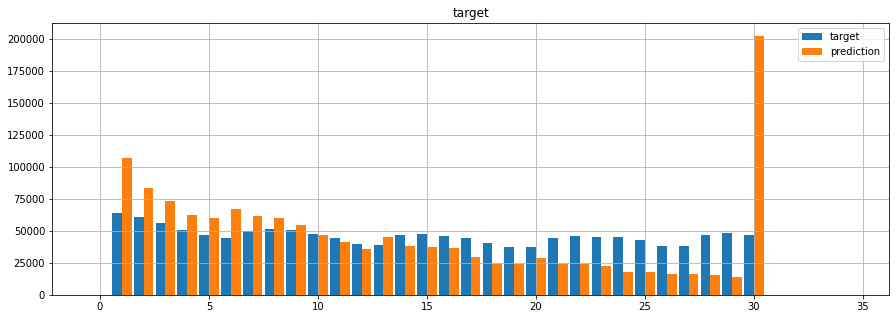

In [21]:
plt.figure(figsize=(15,5))
plt.hist(
    [id_preds.query("inventory_days <= 31").inventory_days.values, 
     id_preds.query("inventory_days <= 31").idp_clip.values], 
    bins=np.arange(0,36), 
    rwidth=0.9, 
    align="left",
    label=["target","prediction"]
)
plt.title("target")
plt.legend(loc="best")
plt.grid()
plt.show()

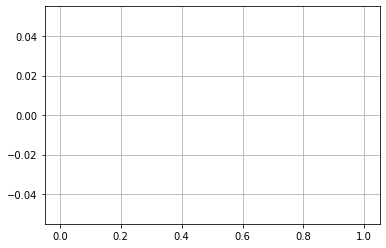

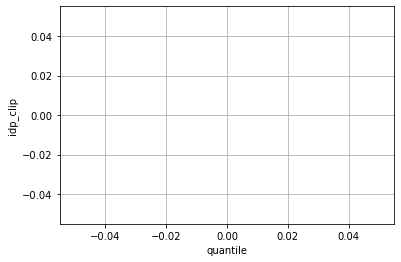

In [22]:
id_preds.query("inventory_days > 30").idp_clip.hist()
plt.show()

id_preds.query("inventory_days > 30").idp_clip.quantile(np.arange(0,1,0.01)).plot()
plt.xlabel("quantile")
plt.ylabel("idp_clip")
plt.grid()
plt.show()

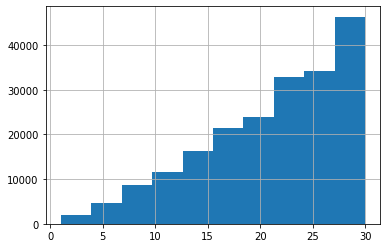

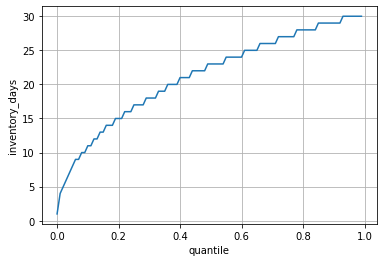

In [23]:
id_preds.query("idp_clip >= 30 & inventory_days <= 30").inventory_days.hist()
plt.show()

id_preds.query("idp_clip >= 30 & inventory_days <= 30").inventory_days.quantile(np.arange(0,1,0.01)).plot()
plt.xlabel("quantile")
plt.ylabel("inventory_days")
plt.grid()
plt.show()

In [24]:
idx = id_preds.query("inventory_days > 31").index
id_preds.loc[idx, "inventory_days"] = 35

idx = id_preds.query("idp > 31").index
id_preds.loc[idx, "idp"] = 35
idx = id_preds.query("idp < 1").index
id_preds.loc[idx, "idp"] = 1

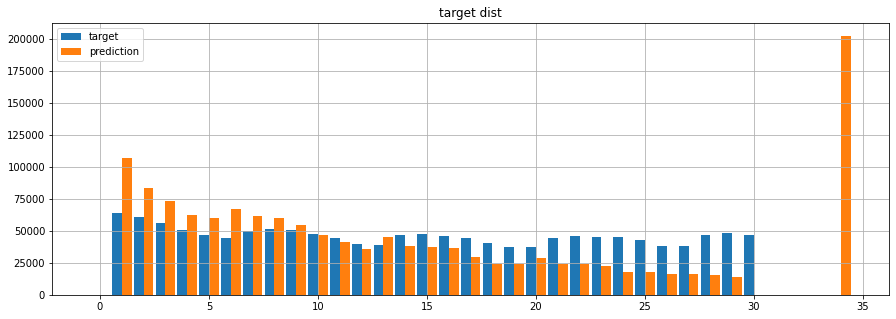

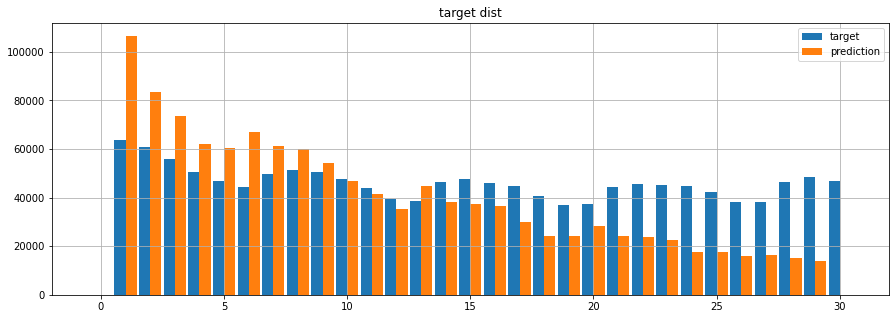

In [25]:
plt.figure(figsize=(15,5))
plt.hist([id_preds.inventory_days.values, id_preds.idp.values], bins=np.arange(0,36), rwidth=0.9, align="left", label=["target","prediction"])
plt.grid()
plt.title("target dist")
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(15,5))
plt.hist([id_preds.inventory_days.values, id_preds.idp.values], bins=np.arange(0,32), rwidth=0.9, align="left", label=["target","prediction"])
plt.grid()
plt.title("target dist")
plt.legend(loc="best")
plt.show()

In [26]:
dataset = (
    dataset
    .merge(id_preds, how="inner", on="sku")
)
dataset["idp_naive1"] = dataset.eval("target_stock / q_mean")
dataset["idp_naive2"] = dataset.eval("target_stock / q_mean_raw")
dataset.isna().sum(axis=0)

sku                             0
date                            0
sold_quantity                   0
current_price                   0
listing_type                    0
shipping_logistic_type          0
shipping_payment                0
minutes_active                  0
item_domain_id                  0
item_id                         0
site_id                         0
product_id                1336359
product_family_id         1226592
item_domain_id_glob             0
product_id_glob           1336359
product_family_id_glob    1226592
q_mean                          0
q_std                           0
was_active                      0
had_sales                       0
tr_points                       0
completeness                    0
minutes_rate1                   0
minutes_rate2                   0
activity_rate1                  0
activity_rate2                  0
sales_rate1                     0
sales_rate2                     0
q_mean_raw                      0
q_std_raw     

In [27]:
input_cols = [
    # sold_quantity stats
    "q_mean",
    "q_mean_raw",
    "q_std",
    "q_std_raw",
    "std_days",
    "std_days_raw",
    
    # activity on history
    "completeness",
    "minutes_rate1",
    "minutes_rate2",
    "activity_rate1",
    "activity_rate2",
    "sales_rate1",
    "sales_rate2",
    # days since no sales
    # days with consecutive sales
    # days since inactive
    # days since active
    
    # ID predictions
    "target_stock",
    "idp_clip",
    "no_stockout",
    "idp_naive1",
    "idp_naive2",
    
    # others
    "site_id",
]
categ_cols = [
    "site_id",
]

print("# feats:", len(input_cols))

# feats: 19


In [28]:
encoder = ce.OneHotEncoder()
transformed = encoder.fit_transform(dataset[categ_cols])
dataset[transformed.columns] = transformed.values
for col in categ_cols:
    input_cols.remove(col)
input_cols.extend(transformed.columns.tolist())

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
assert dataset[input_cols].isna().sum(axis=0).sum() == 0

In [30]:
idx = dataset.query("inventory_days > 30").index
dataset = dataset.drop(idx).reset_index(drop=True)
dataset["inventory_days"] = dataset["inventory_days"].astype(int)

print(f"Number of rows removed: {len(idx)}")

Number of rows removed: 0


In [31]:
# generate the target for each sku (cumulative distribution)
y_true = dataset.inventory_days.values.copy()
y_true_one_hot = np.zeros((len(y_true),30), dtype=np.float64)
y_true_one_hot[range(len(y_true)), y_true-1] = 1
y_true = np.cumsum(y_true_one_hot, axis=1)
targets = pd.DataFrame(y_true, index=dataset.sku.values)
targets.index.rename("sku", inplace=True)
targets = targets.reset_index()

In [32]:
gc.collect()

0

***
## model definition

In [33]:
@torch.jit.script
def rps_loss(preds, targets):
    return torch.mean(torch.sum((targets - preds)**2, dim=1))

@torch.jit.script
def discont_loss(probs):
    return torch.mean(torch.sqrt(torch.sum(torch.diff(probs, dim=1)**2, dim=1)))

class SoftOrdering1DCNN(nn.Module):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, alpha=0):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.alpha = alpha
        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = nn.Conv1d(
            cha_input, 
            cha_input*K, 
            kernel_size=3, 
            stride = 1, 
            padding=1,  
            groups=cha_input, 
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input*K, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)
        
        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        conv4 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            groups=cha_hidden, 
            bias=False)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)

        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm2 = nn.BatchNorm1d(output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.sparsemax = Sparsemax(dim=1)
        self.entmax = Entmax15(dim=1)

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = nn.functional.celu(self.dense1(x))

        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)

        x = self.batch_norm_c1(x)
        x = nn.functional.leaky_relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = nn.functional.leaky_relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = nn.functional.leaky_relu(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x =  x + x_s
        x = nn.functional.leaky_relu(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.dense2(x)

        #x = nn.functional.softmax(x, dim=1)
        x = self.entmax(x)
        #x = self.sparsemax(x)

        return x

    def training_step(self, batch):
        x,y = batch
        probs = self.forward(x)
        probs_cum = torch.cumsum(probs, dim=1)
        loss1 = rps_loss(probs_cum, y)
        loss2 = discont_loss(probs)
        return loss1 + (self.alpha * loss2)
    
    def validation_step(self, batch):
        x,y = batch
        probs = self.forward(x)
        probs_cum = torch.cumsum(probs, dim=1)
        loss = rps_loss(probs_cum, y)
        return loss
    
    def prediction_step(self, batch):
        x,_ = batch
        pred = self.forward(x)
        return pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=1e-2, 
            weight_decay=1e-5
        )
        scheduler = ReduceLROnPlateau(
            optimizer, 
            mode="min", 
            factor=0.5, 
            patience=5, 
            min_lr=1e-5
        )
        return optimizer,scheduler

***
## model training

In [34]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#gkf = GroupKFold(n_splits=5)
#gkf_split = gkf.split(dataset, groups=dataset["sku"])
strat_cols = ["item_domain_id", "no_stockout", "inventory_days"]
mskf_split = mskf.split(dataset, dataset[strat_cols])

models_by_fold = list()
oof_preds = list()

for fold,(train_idx,valid_idx) in enumerate(mskf_split):
    print(f"Train model for fold: {fold+1}/5")
    
    x_train = dataset.loc[train_idx,input_cols]
    y_train = targets.iloc[train_idx,1:]
    x_valid = dataset.loc[valid_idx,input_cols]
    y_valid = targets.iloc[valid_idx,1:]
    
    train_dset = TensorDataset(
        torch.tensor(x_train.values, dtype=torch.float),
        torch.tensor(y_train.values, dtype=torch.float),
    )
    valid_dset = TensorDataset(
        torch.tensor(x_valid.values, dtype=torch.float),
        torch.tensor(y_valid.values, dtype=torch.float),
    )
    train_dataloader = DataLoader(
        train_dset, 
        batch_size=2048, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )
    valid_dataloader = DataLoader(
        valid_dset, 
        batch_size=16384, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    model = SoftOrdering1DCNN(
        input_dim=len(input_cols),
        output_dim=30,
        sign_size=4,
        cha_input=32,
        cha_hidden=32,
        K=2,
        dropout_input=0.2, 
        dropout_hidden=0.2, 
        dropout_output=0.1,
        alpha=5.
    )
    display(torchinfo.summary(model))
    
    model,monitor = pax.iterative_train(
        model, 
        train_dataloader, 
        valid_dataloader,
        min_epochs=20,
        max_epochs=100, 
        patience=12,
        #clip_value=0.1,
    )
    model.load_state_dict(monitor.best_model_state)
    models_by_fold.append(model)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(5, len(monitor.train_loss)), monitor.train_loss[5:], label="train")
    plt.plot(np.arange(5, len(monitor.valid_loss)), monitor.valid_loss[5:], label="valid")
    plt.xlabel("epoch")
    plt.ylabel("rps")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    preds_proba = pax.iterative_predict(model, valid_dataloader).detach().cpu().numpy()
    preds_proba = pd.DataFrame(preds_proba, index=valid_idx)
    oof_preds.append(preds_proba)


Train model for fold: 1/5


Layer (type:depth-idx)                   Param #
SoftOrdering1DCNN                        --
├─BatchNorm1d: 1-1                       42
├─Dropout: 1-2                           --
├─Linear: 1-3                            2,816
├─BatchNorm1d: 1-4                       64
├─Conv1d: 1-5                            193
├─AdaptiveAvgPool1d: 1-6                 --
├─BatchNorm1d: 1-7                       128
├─Dropout: 1-8                           --
├─Conv1d: 1-9                            6,145
├─BatchNorm1d: 1-10                      64
├─Dropout: 1-11                          --
├─Conv1d: 1-12                           3,073
├─BatchNorm1d: 1-13                      64
├─Conv1d: 1-14                           97
├─AvgPool1d: 1-15                        --
├─Flatten: 1-16                          --
├─BatchNorm1d: 1-17                      64
├─Dropout: 1-18                          --
├─Linear: 1-19                           990
├─Sparsemax: 1-20                        --
├─Entmax15: 1-2

 29%|██▉       | 29/100 [06:16<15:22, 13.00s/it, a_train_loss=4.166388, b_valid_loss=4.138904, c_best_loss=4.122369, g_es_counter=7]


RuntimeError: ignored

In [ ]:
# entmax output
oof_preds = pd.concat(oof_preds)
oof_preds = oof_preds.loc[targets.index,:].copy()
print("RPS:", compute_rps(np.cumsum(oof_preds.values, axis=1), targets.iloc[:,1:].values))

In [35]:
# entmax output
oof_preds = pd.concat(oof_preds)
oof_preds = oof_preds.loc[targets.index,:].copy()
print("RPS:", compute_rps(np.cumsum(oof_preds.values, axis=1), targets.iloc[:,1:].values))

RPS: 4.075973190885728


In [36]:
gc.collect()

1012548

***
## inspecting the predictions

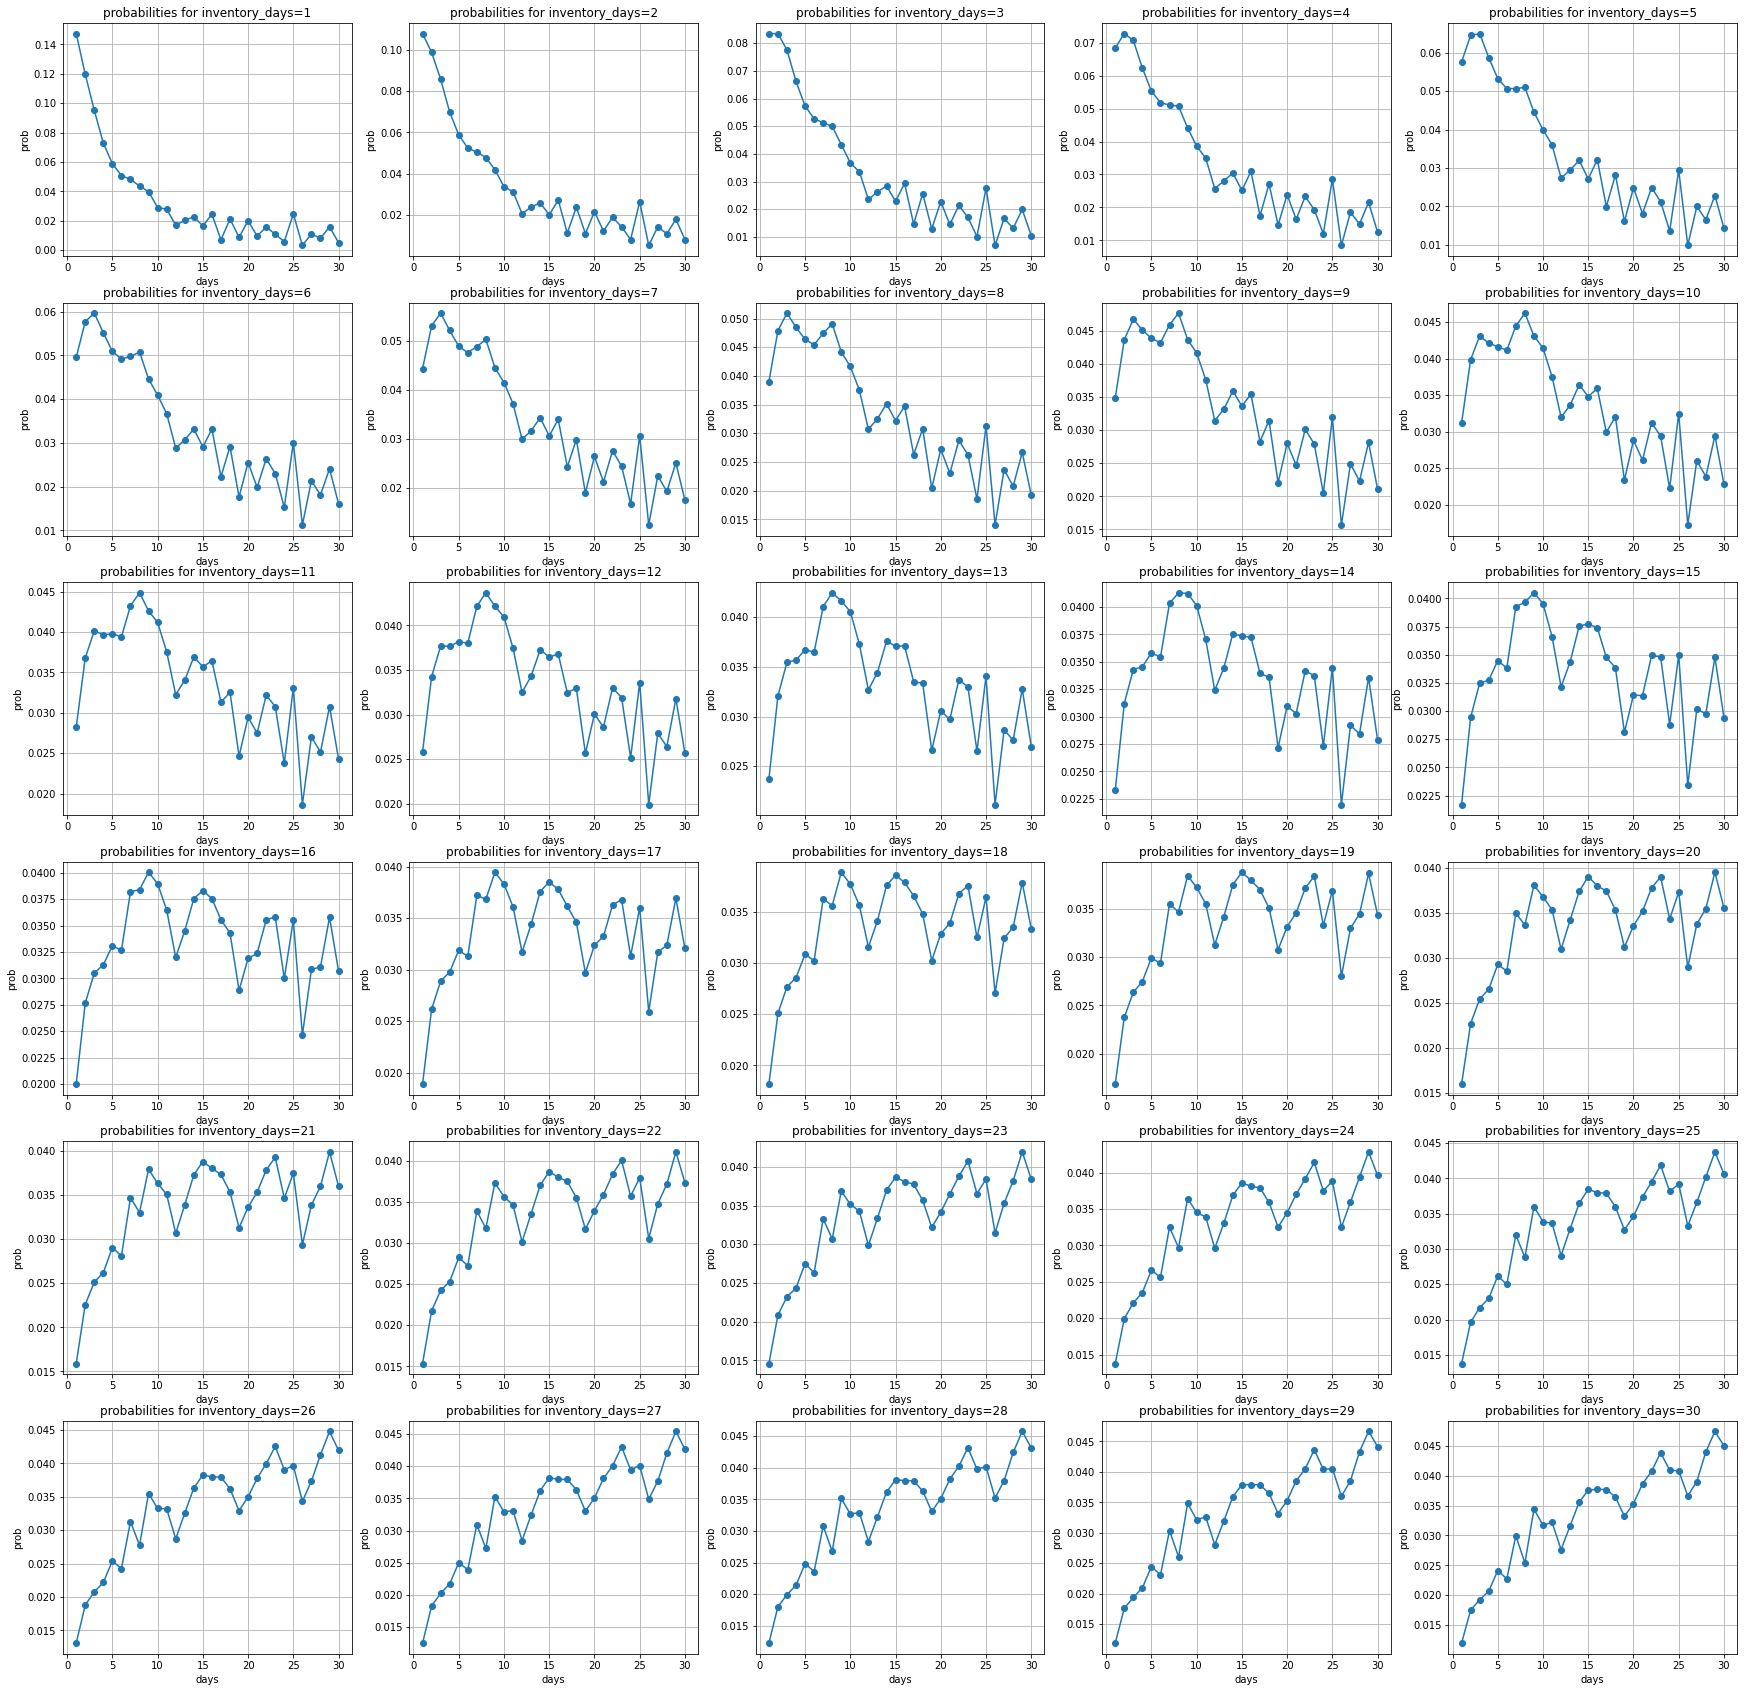

In [37]:
plt.figure(figsize=(30,30))
for idays in range(1,31):
    idx = dataset.query("inventory_days == @idays").index
    averaged = oof_preds.loc[idx].mean(axis=0)
    plt.subplot(6,5,idays)
    plt.plot(averaged.index+1, averaged.values, "o-")
    plt.title(f"probabilities for inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()

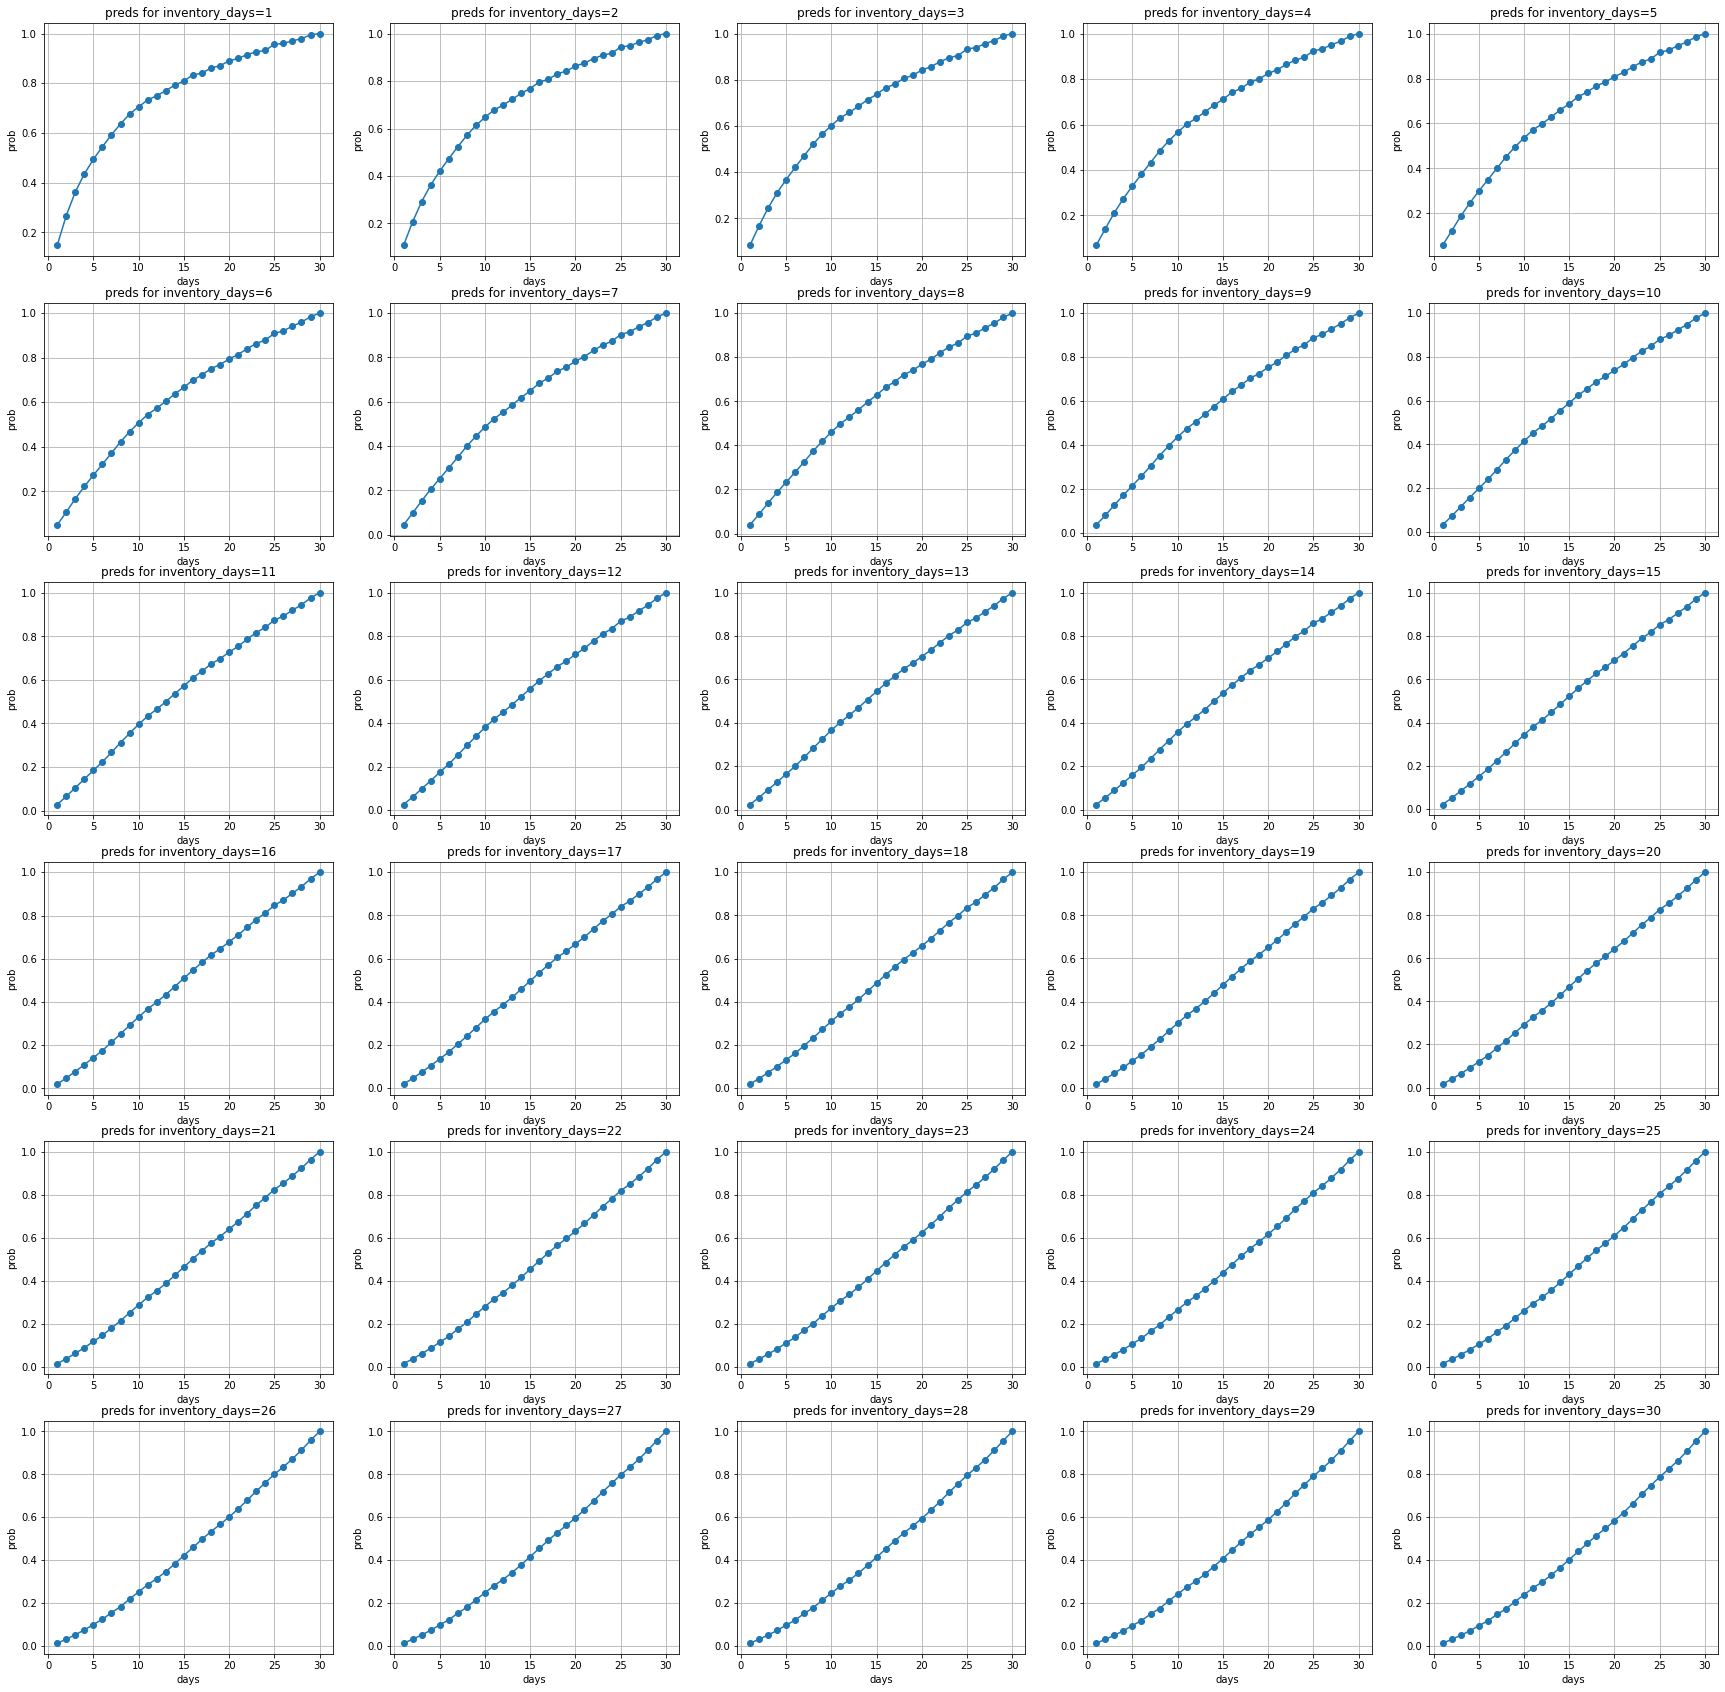

In [38]:
plt.figure(figsize=(30,30))
for idays in range(1,31):
    idx = dataset.query("inventory_days == @idays").index
    averaged = np.cumsum(oof_preds.loc[idx], axis=1).mean(axis=0)
    plt.subplot(6,5,idays)
    plt.plot(averaged.index+1, averaged.values, "o-")
    plt.title(f"preds for inventory_days={idays}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()


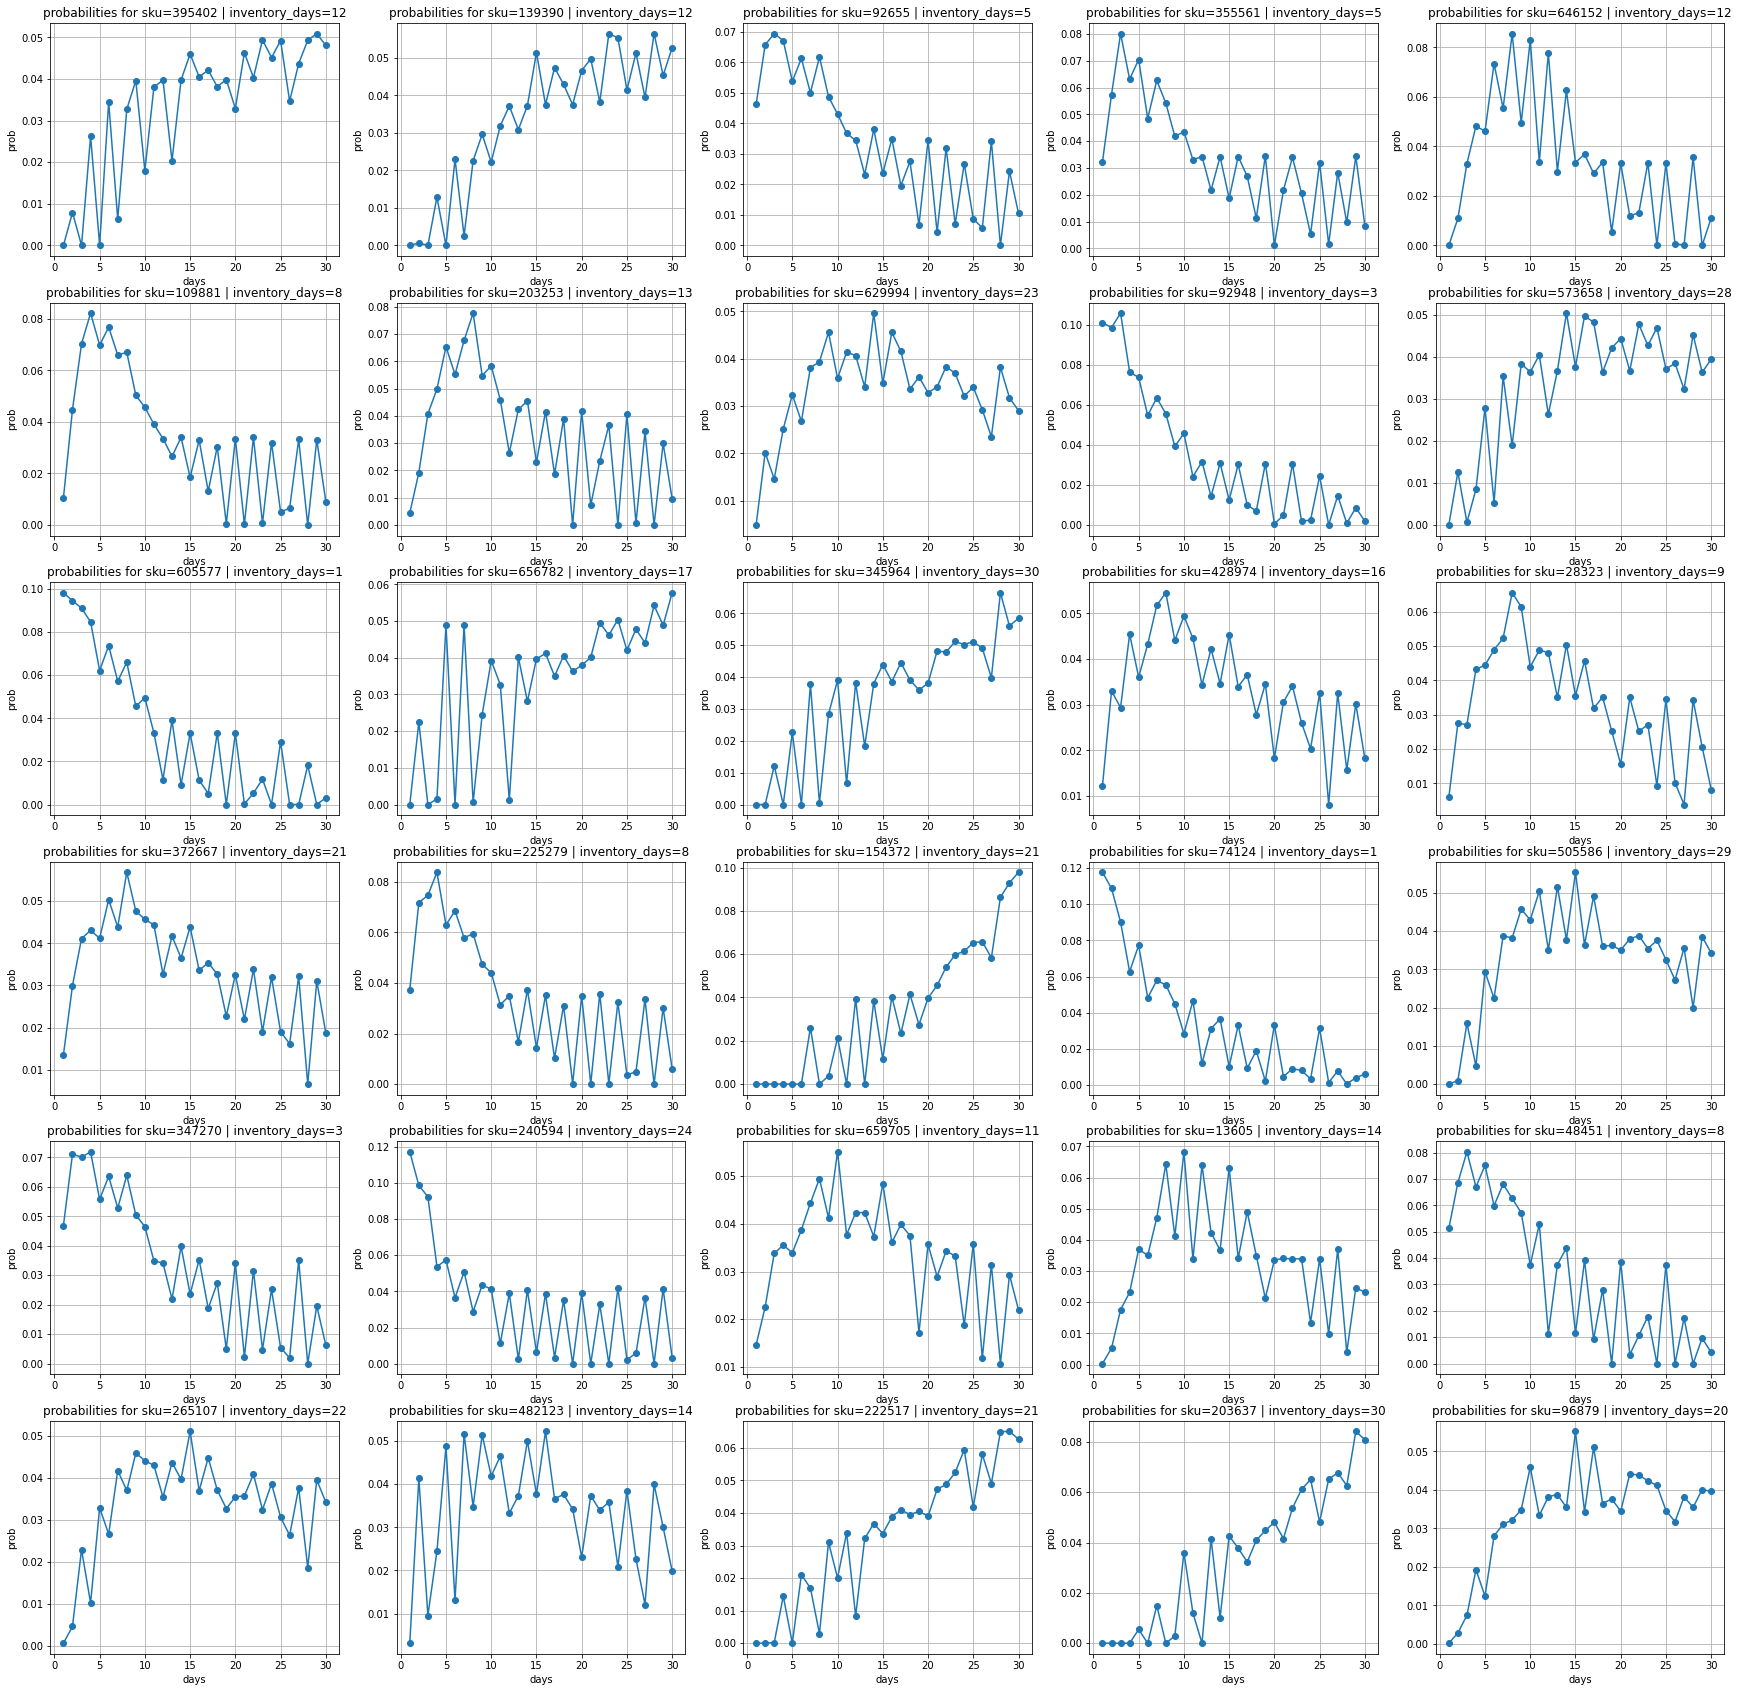

In [39]:
sample = dataset.sample(30)

plt.figure(figsize=(30,30))
for i,(idx,row) in enumerate(sample.iterrows()):
    plt.subplot(6,5,i+1)
    plt.plot(oof_preds.loc[idx].index+1, oof_preds.loc[idx].values, "o-")
    plt.title(f"probabilities for sku={row.sku} | inventory_days={row.inventory_days}")
    plt.grid()
    plt.xlabel("days")
    plt.ylabel("prob")
plt.show()

***
## inference - data preparation

In [35]:
del dataset, raw, oof, valid, feat
gc.collect()

998971

In [37]:
gc.collect(generation=2)

744

In [41]:
predictions = pd.read_csv(f"{results_path}/preds_m1_lgbm_sub21.csv")
pred_skus = predictions.sku.unique()
len(pred_skus)

526158

In [42]:
dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku in @pred_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
dataset.sku.nunique()

526158

In [44]:
gc.collect()

695

In [45]:
raw = (
    pd.read_parquet(
        f"{input_path}/train_data.parquet", 
        columns=["sku", "date", "sold_quantity", "minutes_active"]
    )
    .query("sku in @pred_skus")
    .sort_values(["sku","date"])
    .reset_index(drop=True)
)
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")
raw.sku.nunique()

526158

In [48]:
torch.cuda.empty_cache()
gc.collect()

723

In [54]:
test = (
    pd.read_csv(f"{input_path}/test_data.csv")
    .query("sku in @pred_skus")
    .reset_index(drop=True)
)
test.sku.nunique()

526158

In [56]:
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")

In [57]:
gc.collect()

242

In [60]:
feat.fit

<bound method Featurador.fit of <features.Featurador object at 0x7f7c4a940bd0>>

In [ ]:

dataset = feat.transform(dataset)

In [ ]:
dataset["was_active"] = dataset.eval("minutes_active > 0")
dataset["had_sales"] = dataset.eval("sold_quantity > 0")

dataset["tr_points"] = dataset.groupby("sku")["date"].transform("count")
dataset["completeness"] = dataset.tr_points / (dataset.date.nunique())

dataset["minutes_rate1"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.tr_points*1440)
dataset["minutes_rate2"] = dataset.groupby("sku")["minutes_active"].transform("sum") / (dataset.date.nunique()*1440)

dataset["activity_rate1"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.tr_points)
dataset["activity_rate2"] = dataset.groupby("sku")["was_active"].transform("sum") / (dataset.date.nunique())

dataset["sales_rate1"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.tr_points)
dataset["sales_rate2"] = dataset.groupby("sku")["had_sales"].transform("sum") / (dataset.date.nunique())

dataset["q_mean_raw"] = dataset.groupby("sku")["sold_quantity"].transform("mean")
dataset["q_std_raw"] = dataset.groupby("sku")["sold_quantity"].transform("std")

In [ ]:
# imputation of nan values
idx = dataset[dataset["q_mean"].isna()].index
dataset.loc[idx, "q_mean"] = dataset.q_mean.median()

idx = dataset[dataset["q_std"].isna()].index
dataset.loc[idx, "q_std"] = dataset.q_std.median()

idx = dataset[dataset["q_mean_raw"].isna()].index
dataset.loc[idx, "q_mean_raw"] = dataset.q_mean_raw.median()

idx = dataset[dataset["q_std_raw"].isna()].index
dataset.loc[idx, "q_std_raw"] = dataset.q_std_raw.median()

In [ ]:
dataset["std_days"] = dataset.eval("q_std / q_mean")
idx = dataset[dataset["std_days"].isna()].index
dataset.loc[idx, "std_days"] = dataset.std_days.median()
print(len(idx))

dataset["std_days_raw"] = dataset.eval("q_std_raw / q_mean_raw")
idx = dataset[dataset["std_days_raw"].isna()].index
dataset.loc[idx, "std_days_raw"] = dataset.std_days_raw.median()
print(len(idx))

In [ ]:
dataset = dataset.drop_duplicates(subset=["sku"], ignore_index=True)
display(dataset)
gc.collect()

In [ ]:
# inventory days predictions
predictor = IDP()
predictor.fit(predictions)

preds1 = list()
preds2 = list()
for i,row in tqdm(test.iterrows()):
    idp,idp_clip = predictor.predict(int(row.sku), int(row.target_stock))
    preds1.append(idp)
    preds2.append(idp_clip)
    
id_preds = pd.DataFrame({
    "sku":test.sku.values, 
    "idp":preds1, 
    "idp_clip":preds2}
)
id_preds["no_stockout"] = id_preds.eval("idp > 30").astype(int)
id_preds = pd.merge(id_preds, test, how="inner", on="sku")
id_preds

In [ ]:
dataset = (
    dataset
    .merge(id_preds, how="inner", on="sku")
)
dataset["idp_naive1"] = dataset.eval("target_stock / q_mean")
dataset["idp_naive2"] = dataset.eval("target_stock / q_mean_raw")
dataset.isna().sum(axis=0)

In [ ]:
transformed = encoder.transform(dataset[categ_cols])
dataset[transformed.columns] = transformed.values

In [ ]:
assert dataset[input_cols].isna().sum(axis=0).sum() == 0

***
## inference

In [ ]:
preds_by_fold = list()

for i,model in enumerate(models_by_fold):
    print(f"Making predictions with model: {i+1}/5")
    
    x_test = dataset.loc[:,input_cols]
    x_test = torch.tensor(x_test.values, dtype=torch.float, device=device)
    preds_proba = model(x_test).detach().cpu().numpy()
    preds_by_fold.append(preds_proba)

In [ ]:
preds_proba = np.mean(preds_by_fold, axis=0)
preds_proba = preds_proba / preds_proba.sum(axis=1).reshape(-1,1)
preds_proba = pd.DataFrame(preds_proba, index=dataset.sku.values)

In [ ]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
unpreds_proba = np.ones((len(unpredictable),30)) / 30.
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

***
## generate submission

In [ ]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [ ]:
preds_proba_mrg.max(axis=1).max()

In [ ]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() <= 1

In [ ]:
SUB_NBR

In [ ]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***